# Step 1: Set Up the Environment
Prepare our Python environment with necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Step 2: Load and Inspect the Data
Explore the Iris dataset's structure and characteristics.

In [2]:
# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Display dataset information
print("Dataset Description:")
print("-------------------")
print(iris.DESCR)

# Create and display DataFrame
df = pd.DataFrame(X, columns=iris.feature_names)
print("\nFirst few rows of the dataset:")
print("-------------------")
print(df.head())

# Basic statistics
print("\nBasic Statistics:")
print("-------------------")
print(df.describe())

Dataset Description:
-------------------
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distr

# Step 3: Split the Data into Training and Testing Sets
Prepare our data for model training and evaluation.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 120
Testing set size: 30


# Step 4: Implement XGBoost
Train and evaluate our XGBoost classifier.


In [4]:
# Initialize and train XGBoost
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("\nXGBoost Results:")
print("-------------------")
print(f"Accuracy: {accuracy_xgb:.3f}")


XGBoost Results:
-------------------
Accuracy: 1.000


# Step 5: Implement LightGBM
Train and evaluate our LightGBM classifier

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.073920
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

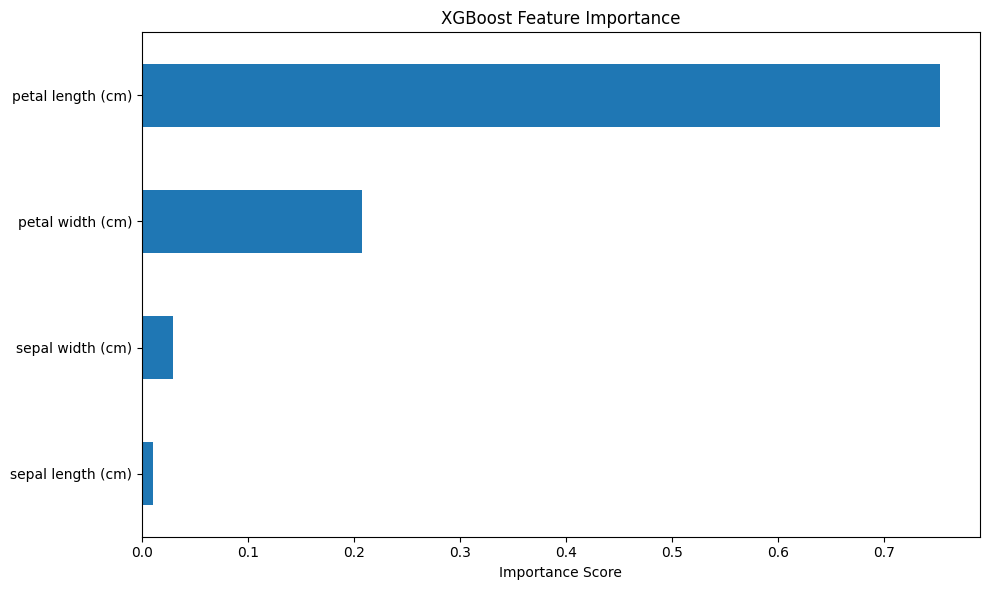

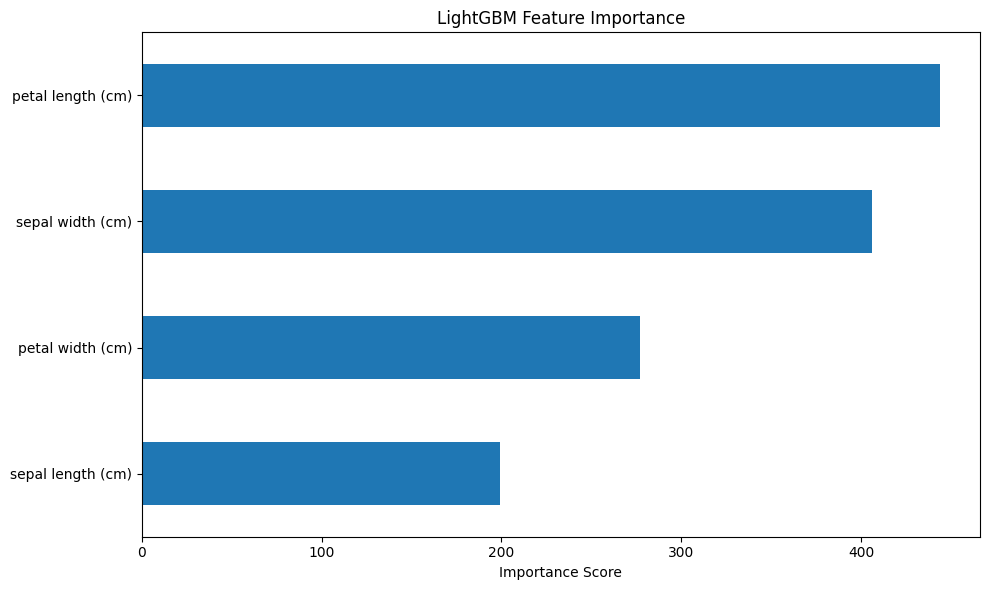

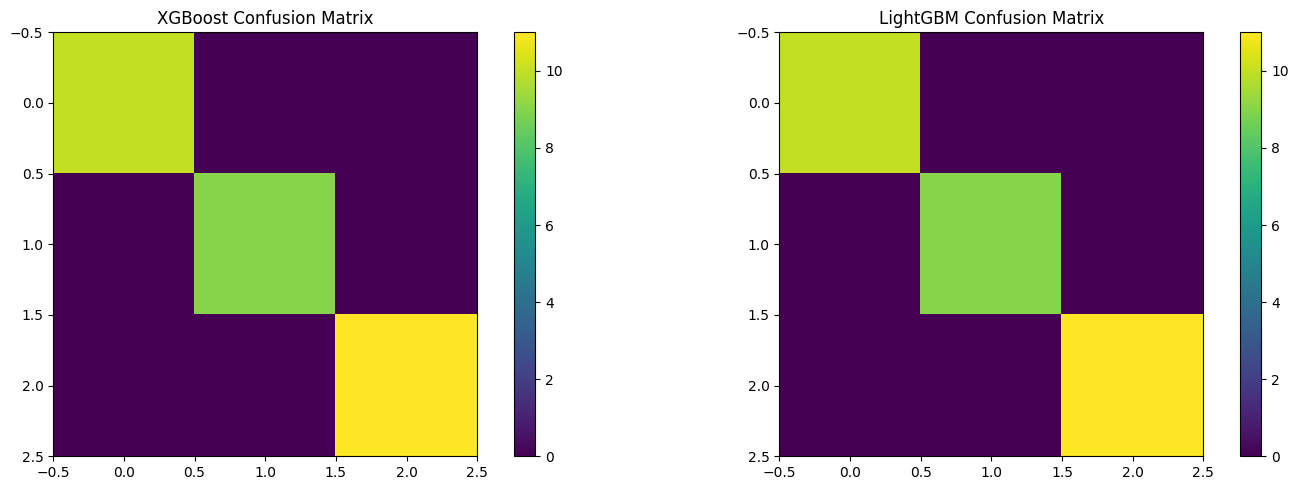

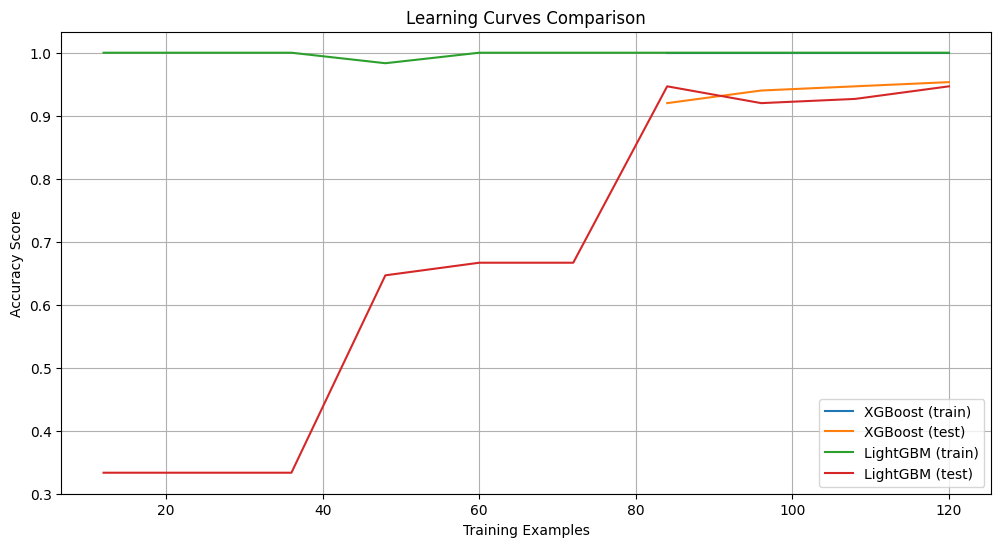

In [5]:
# Initialize and train LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_clf.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

print("\nLightGBM Results:")
print("-------------------")
print(f"Accuracy: {accuracy_lgb:.3f}")

# Visualize feature importances for both models
# =====================================

def plot_feature_importance(model, title):
    importances = pd.Series(model.feature_importances_, index=iris.feature_names)
    plt.figure(figsize=(10, 6))
    importances.sort_values().plot(kind='barh')
    plt.title(f'{title} Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_clf, 'XGBoost')
plot_feature_importance(lgb_clf, 'LightGBM')

# Compare model predictions
# =====================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
im = axes[0].imshow(cm_xgb)
axes[0].set_title('XGBoost Confusion Matrix')
plt.colorbar(im, ax=axes[0])

# LightGBM confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
im = axes[1].imshow(cm_lgb)
axes[1].set_title('LightGBM Confusion Matrix')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()


# Learning curves comparison
# =====================================

from sklearn.model_selection import learning_curve

def plot_learning_curves(estimators, X, y, title):
    plt.figure(figsize=(12, 6))

    for name, estimator in estimators.items():
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10))

        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.plot(train_sizes, train_mean, label=f'{name} (train)')
        plt.plot(train_sizes, test_mean, label=f'{name} (test)')

    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

estimators = {
    'XGBoost': xgb_clf,
    'LightGBM': lgb_clf
}

plot_learning_curves(estimators, X, y, 'Learning Curves Comparison')